# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

**a** - контрольная группа\
**b** - тестовая группа

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [18]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

Считываем, смотрим как выглядят данные и запоминаем особеннности

In [19]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep=';')

In [20]:
df.head(3)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a


In [21]:
df.shape

(404770, 3)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Кол-во уникальных номеров юзеров = кол-во строк, значит повторных покупок по идее здесь быть не может.
Достаточно мало уникальных значений у сумм покупок (относительно кол-ва покупающих игроков), что логично, если мы продаем разные наборы / сундуки / ящики с фиксированной стоимостью.

In [23]:
df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

Далее отмечаем тип/статус клиента, где 1 = платящий, а 0 - не платящий, чтобы дальше было проще считать метрики.

In [24]:
df['paying_status'] = np.where(df['revenue'] > 0, 1, 0)

**Посмотрим на описательные статистики групп по отдельности.**\
Видим особенность контрольной группы (а). Так, там по всей видимости присутствуют "киты" , потратившие 37,000 у.е., что больше максимальных трат игроков в тестовой группе более чем в 9 раз. Std из-за этого тоже больше почти в 3 раза чем в тесте.

In [25]:
df.query('testgroup == "a"').describe().round(2)

,user_id,revenue,paying_status
count,202103.00,202103.00,202103.00
mean,202555.91,25.41,0.01
std,116802.33,920.77,0.10
min,2.00,0.00,0.00
25%,101502.50,0.00,0.00
50%,202988.00,0.00,0.00
75%,303559.00,0.00,0.00
max,404769.00,37433.00,1.00


In [26]:
df.query('testgroup == "b"').describe()

,user_id,revenue,paying_status
count,202667.000000,202667.000000,202667.000000
mean,202215.564389,26.751287,0.008906
std,116891.926690,287.324162,0.093952
min,1.000000,0.000000,0.000000
25%,100855.500000,0.000000,0.000000
50%,201821.000000,0.000000,0.000000
75%,303602.500000,0.000000,0.000000
max,404770.000000,4000.000000,1.000000


**Смотрим на распределение данных.**\
Ничего пока не видно, но есть явное смещение влево. Логично, раз у нас много не платащих пользователей.

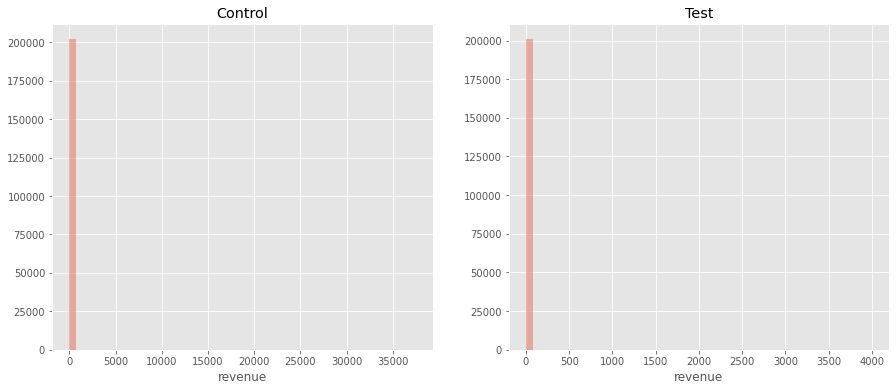

In [27]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))
sns.distplot(df.query('testgroup == "a"').revenue, kde=False, ax=ax[0]).set_title('Control')
sns.distplot(df.query('testgroup == "b"').revenue, kde=False, ax=ax[1]).set_title('Test')
plt.show()

**Попробуем посмотреть только на платящих пользователей**\
Уже лучше, опять видим "китов" в контрольной группе.

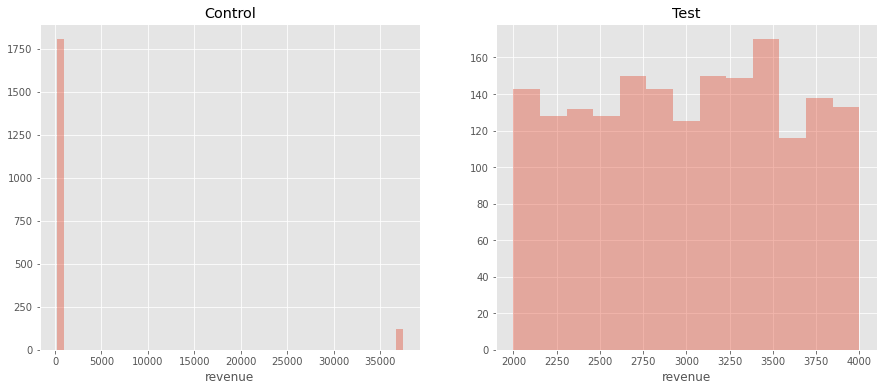

In [28]:
df_paying = df.query('revenue > 0')

fig, ax = plt.subplots(1,2, figsize=(15, 6))
sns.distplot(df_paying.query('testgroup == "a"').revenue, kde=False, ax=ax[0]).set_title('Control')
sns.distplot(df_paying.query('testgroup == "b"').revenue, kde=False, ax=ax[1]).set_title('Test')
plt.show()

Выведем описательные статистики рядом, чтобы удобнее было сравнивать

In [29]:
a = df_paying.query('testgroup == "a"').revenue.describe().round()
b = df_paying.query('testgroup == "b"').revenue.describe().round()
ab = pd.DataFrame(a).rename(columns={'revenue':'control'})
ab['test'] = b
ab

,control,test
count,1928.0,1805.0
mean,2664.0,3004.0
std,9049.0,573.0
min,200.0,2000.0
25%,257.0,2513.0
50%,311.0,3022.0
75%,361.0,3478.0
max,37433.0,4000.0


Посмотрим как много "китов" у нас в контрольной группе и какой у них разброс по суммам.

In [30]:
df_tops = df.query('revenue > 5000')
df_tops.revenue.describe().round(2)

count      123.00
mean     37319.12
std         25.44
min      37293.00
25%      37301.00
50%      37311.00
75%      37329.00
max      37433.00
Name: revenue, dtype: float64

Посмотрим также на распределение платящих пользователей контрольной группы с разбивкой на только 'китов' и без "китов".

Для сравнения также выведем распределение платящих польхователей в тестовой группе.

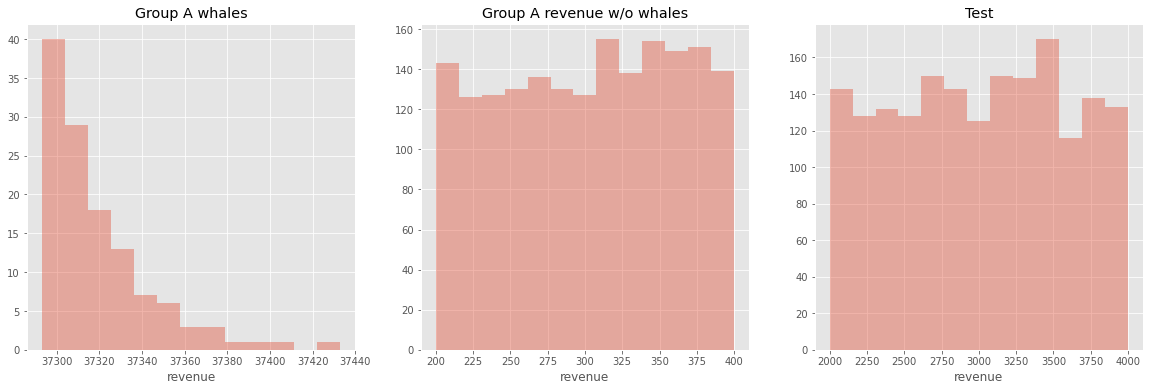

In [31]:
fig, ax = plt.subplots(1,3, figsize=(20, 6))
sns.distplot(df_tops.revenue, kde=False, ax=ax[0])\
   .set_title('Group A whales')
sns.distplot(df_paying.query('testgroup == "a"').query('revenue < 5000').revenue, kde=False, ax=ax[1])\
   .set_title('Group A revenue w/o whales')
sns.distplot(df_paying.query('testgroup == "b"').revenue, kde=False, ax=ax[2]).set_title('Test')
plt.show()

Создадим себе сводную табличку с дополнительными метриками, чтобы сделать промежуточные выводы.

In [32]:
df_metr = df.groupby('testgroup', as_index=False)\
            .agg({'revenue':'sum','user_id':'nunique', 'paying_status':'sum'})\
            .rename(columns={'user_id':'n_users', 'paying_status':'pay_users'})

df_metr['CR'] = round(df_metr.pay_users / df_metr.n_users * 100, 2)
df_metr['ARPU'] = round(df_metr.revenue / df_metr.n_users, 2)
df_metr['ARPPU'] = round(df_metr.revenue / df_metr.pay_users, 2)
df_metr['whales_share'] =  round(df_tops.revenue.sum() / df_metr.query('testgroup == "a"').revenue, 2)

df_metr

,testgroup,revenue,n_users,pay_users,CR,ARPU,ARPPU,whales_share
0,a,5136189,202103,1928,0.95,25.41,2664.00,0.89
1,b,5421603,202667,1805,0.89,26.75,3003.66,NaN


**И так, что мы имеем по результатам изучения данных двух групп?**
* Ни одна из групп не распределена нормально.

* Особенностью контрольной группы является наличие "китов" - игроков кто потратил очень много.\
Всего **123 подобных игрока (около 6% от всех платящих) принесли 89% выручки**.

* ARPU (+5%) и средний чек / ARPPU (+11%) на первый взгляд действительно выше у акции b (тестовая группа).\
В нашем случае средний чек / ARPPU это одно и то же, т.к. у каждой покупки уникальный игрок.

* Конверсия у тестовой группы при этом ниже на 0,06 пунктов.
* Выручка в тестовой группе выше, но и кол-во игроков попавших в эту группу больше

Перед тем как принять решение о том, что лучше, хотелось бы еще проверить статистическую значимость получившихся различий в группах.

Учитывая особенности данных, наиболее очевидными способами проверки являются U-критерий Манна-Уитни или Bootstrap.

Однако, поскольку одним из условий применения критерия Манна-Уитни является то, что одинаковые значения в выборке должны быть сведены к минимуму (все числа должны быть разными) применить его в данном случае мы не можем. При проверке данных на уникальные значения в самом начале мы видели что повторяющиеся значения есть и их достаточно много.

Соответственно, используем **Bootstrap**. Проверять, в качестве примера, будем ARPU, поскольку в условии задачи говорится именно про него.

In [33]:
sample_1 = df[df.testgroup == "b"].revenue
sample_2 = df[df.testgroup == "a"].revenue

In [34]:
# Сначала задаем функию
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000,
    statistic = np.mean, # указываем интересующую нас статистику
    bootstrap_conf_level = 0.95
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) #применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

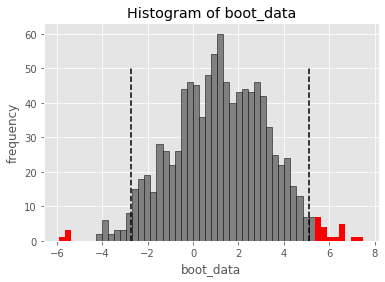

In [35]:
booted_data_ARPU = get_bootstrap(sample_1, sample_2)

In [36]:
booted_data_ARPU["p_value"].round(2)

0.57

In [37]:
booted_data_ARPU["quants"]

,0
0.025,-2.754476
0.975,5.130521


P-value оказался больше 0.05, что не дает нам оснований отклонить нулевую гипотезу о равестве двух выборок.\
Это значит, что **статистически значемых различий между ARPU акций a и b нет**.

Выведем все остальные, возможные к подсчету метрики, чтобы поговорить и о них.

In [38]:
df_metr

,testgroup,revenue,n_users,pay_users,CR,ARPU,ARPPU,whales_share
0,a,5136189,202103,1928,0.95,25.41,2664.00,0.89
1,b,5421603,202667,1805,0.89,26.75,3003.66,NaN


Отвечая на вопрос: "Какие метрики стоит проанализировать для принятия правильного решения и как?", помимо APRU, я бы дальше также проанализировал:

* **Paying Share** - платящие игроки / активные игроки.\
В нашем случае это то же самое что и конверсия. Анализируем вместе с ARPPU, чтобы понять за счет чего именно рост / падение выручки.\
По данным задания кажется что доля платящих упала, но рост среднего чека сказался на выручке положительно.

* **ARPPU** - выручка / платящие игроки.\
Анализируем вместе с Paying Share, чтобы понимать какие измения увеличили / уменьшили доход.\
В задании рост ARPPU сказался на выручке положительно, несмотря на падение доли платящих.\
Если бы в предоставленных данных были повторные платежи, то как раз ARPPU помогал бы их хорошо отслеживать.

* **Конверсия** - платящие игроки / все игроки.\
Смотрим какая конверсия у разных акций. Если, где-то  CR ниже, то анализуем условия и настройки таргета акции, потому что, например, может сложиться так, что акционные стартовые наборы предлагаются высокоуровневым игрокам, а не новичкам.\
Опять же, если бы в предоставленных данных были повторные платежи, то можно было бы анализировать конверсию с разделением на платежи. Например, конверсию первого и повторного, что дало бы больше понимания о поведении игроков.

* **Revenue** - смотрим где она больше и анализуем напрямую влияющие метрики (ARPPU, Paying Users, Конверсия), чтобы понять за счет чего конкретно рост.

* **Retention** - доля пользователей, зашедших в приложение спустя n-дней.\
Посмотрел бы если бы условия акции подразумевали ежедневное возвращение для получения бОльшего количества контента.

Все изменения проверяем на стат-значимость и если изменения будут значимыми, то выбираем тестовый вариант как лучший.

Однако, если стат-значимых различий у других показателей нет (как с ARPU), кажется, что **лучшим вариантом будет акция а (контрольная)**, в которой, при прочих равных, есть киты, которых очень трудно найти и сегмент которых важно иметь в продукте поскольку он приносит большой доход (по-крайней мере если верить книге Сабирова "Игра в цирфы").

Также мое мнение зависило бы от ответов на следущие вопросы (в условиях задания их сейчас не найти):
* Каковы условия акций?
* Почему в данных акции 'а' киты есть, а в акции 'b' нет? Это просто случайность, система сплитования сработала некорректно или условия одной из акций позволяют китам появиться / бесконечно закупаться?
* Киты это новые игроки или старые?

**P.S.** Возможно стоило вообще иключить китов из анализа, чтобы всё можно было просто и понятно сравнить, но отсечь 89% выручки было как-то неправильно, поэтому решил, что лучше все таки сделать так, как сделал.
